# oscillator.ipynb

author: [astellon](https://github.com/astellon)

Analog Waveform Oscillator Implementation in Julia on Jupyter

## The Version of Julia

In [1]:
versioninfo()

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-7700K CPU @ 4.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


## BLIT

In [2]:
using Pkg, Plots
gr()

Plots.GRBackend()

In [3]:
#global variables
fs = 44100.0
f  = 441.0
P  = fs/f

100.0

In [4]:
function SincM(t, M)
    if t == 0
        return 1
    end
    return sin(pi*t)/(M*sin(pi*t/M))
end

SincM (generic function with 1 method)

M = 2 * fld(P, 2) - 1 = 99.0


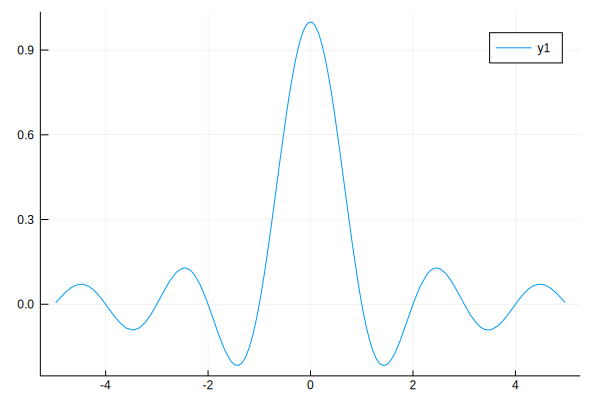

In [5]:
@show M = 2*fld(P, 2)-1
plot(t->SincM(t, M))

In [6]:
let
    global BLIT
    M = 2*fld(P, 2) - 1

    function BLIT(n)
        return (M/P)*SincM(M*n/P, M)
    end
end

BLIT (generic function with 1 method)

In [7]:
plot([0:1:10P], BLIT)
savefig("blit.png")

In [8]:
C1 = sum(BLIT.(0:P-1))/P

0.010000000000000089

In [9]:
let
    sumofblit = 0.0
    global function BLITtri(n)
        n %= P
        sumofblit += BLIT(n) - C1
    end
end

BLITtri (generic function with 1 method)

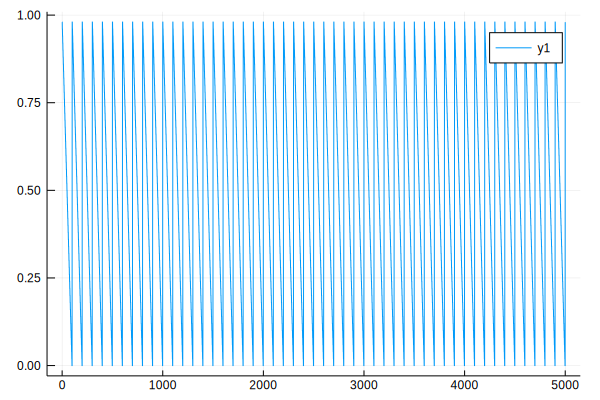

In [10]:
plot([0:50P], BLITtri)

In [11]:
function biBLIT(n)
    global P
    return BLIT(n) - BLIT(n - P/2)
end

biBLIT (generic function with 1 method)

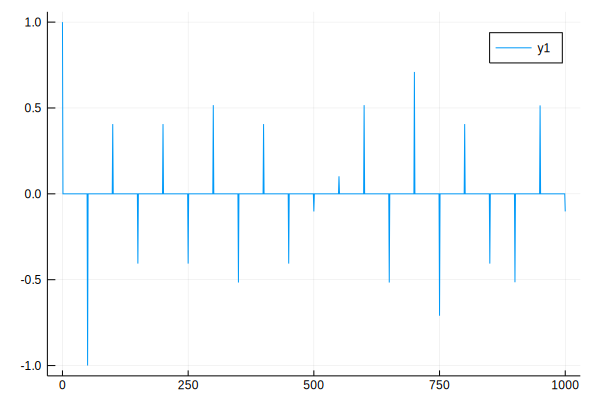

In [12]:
plot([0:10P], biBLIT)

In [13]:
let
    sumofblit = 0.0
    global function BLITsqr(n)
        n %= P
        sumofblit += biBLIT(n)
    end
end

BLITsqr (generic function with 1 method)

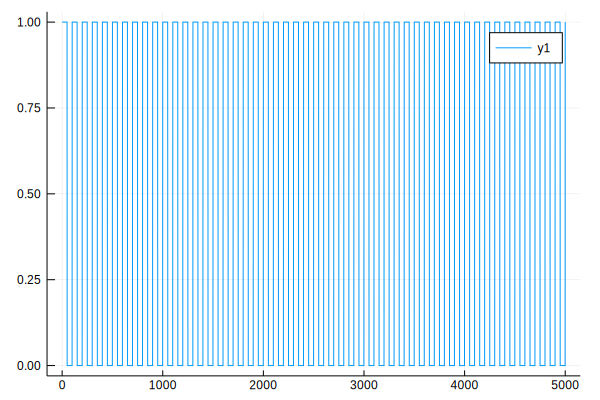

In [14]:
plot([0:50P], BLITsqr)

## minBLEP

ref. [Hard Sync Without Aliasing](http://www.cs.cmu.edu/~eli/papers/icmc01-hardsync.pdf)

In [15]:
using FFTW

In [16]:
window(n) = [1; 2*ones(Float64, fld(n, 2)-1); ones(Float64, 1-n%2); zeros(Float64, fld(n, 2)-1)]

function rceps(x)
  y  = real.(ifft(log.(abs.(fft(x)))))
  n  = length(x)
  w  = [1; 2*ones(Float64, fld(n, 2)-1); ones(Float64, 1-n%2); zeros(Float64, fld(n, 2)-1)]
  ym = real.(ifft(exp.(fft(w.*y))))
end

rceps (generic function with 1 method)

In [17]:
t = collect(-16:32/1024:16)[1:1024];

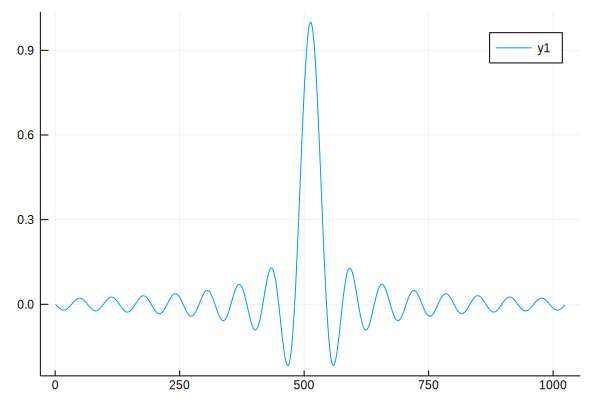

In [18]:
s = sinc.(t)
plot(s)

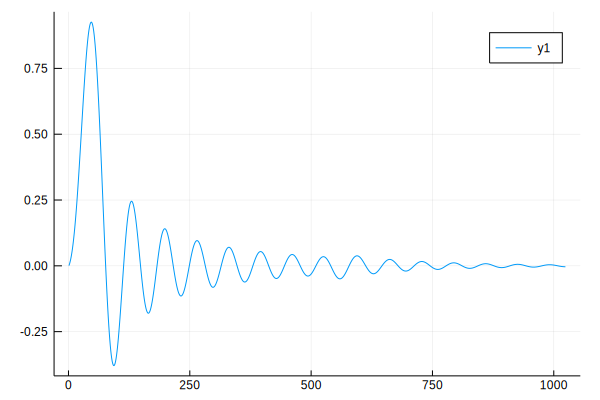

In [19]:
r = rceps(sinc.(t))
plot(r)

In [20]:
function int(x)
    ret = Array{eltype(x), 1}()
    sum = 0
    for xn in x
        sum += xn
        ret = [ret; sum]
    end
    ret
end

int (generic function with 1 method)

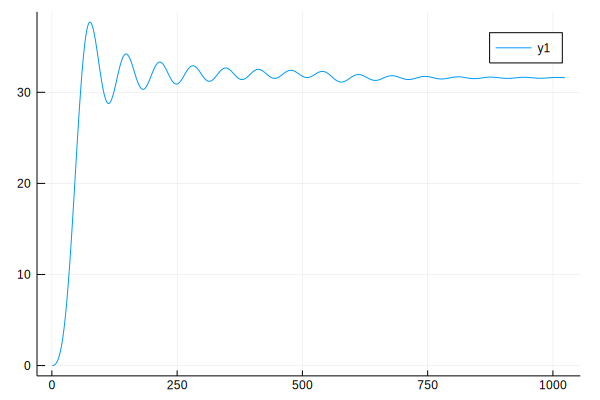

In [21]:
i = int(r)
plot(i)

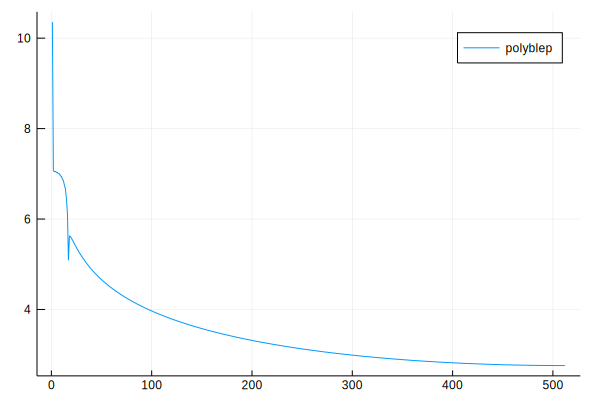

In [22]:
plot(log.(abs.(fft(i)))[1:fld(length(i),2)], label="polyblep")

## plolyBLEP

In [23]:
f = 10

10

In [24]:
function nativesaw(t)
    t = t*f
    return 2 * (t - floor(t)) -1
end

nativesaw (generic function with 1 method)

In [25]:
function polyblep(t)
    dt = f/fs
    if t < dt
        t = t / dt
        return -t^2 + 2t - 1
    elseif t > 1 - dt
        t = (t - 1) / dt
        return t^2 + 2t + 1
    else
        return 0
    end
end

polyblep (generic function with 1 method)

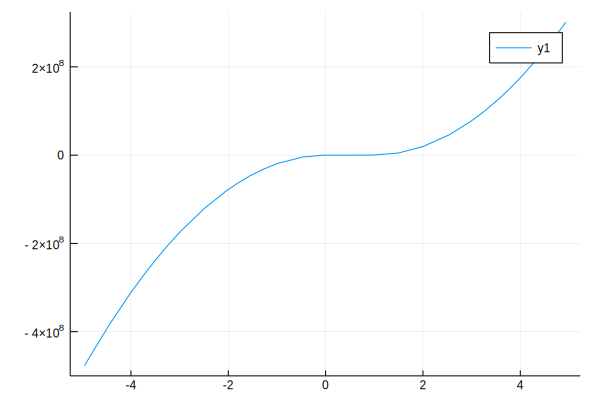

In [26]:
plot(polyblep)

In [27]:
let
    phase = 0
    dp = 2*pi*f/fs
    global nextsample
    function nextsample()
        value = nativesaw(phase)
        value -= polyblep(phase/2/pi)
        phase += dp
        phase = mod2pi(phase)
        return value
    end
end

nextsample (generic function with 1 method)

In [28]:
a = map(1:1024) do i
    nextsample()
end;

In [29]:
let
    phase = 0
    dp = 2*pi*f/fs
    global 
    function nextsample_native()
        value = nativesaw(phase)
        phase += dp
        phase = mod2pi(phase)
        return value
    end
end

nextsample_native (generic function with 1 method)

In [30]:
b = map(1:1024) do i
    nextsample()
end;

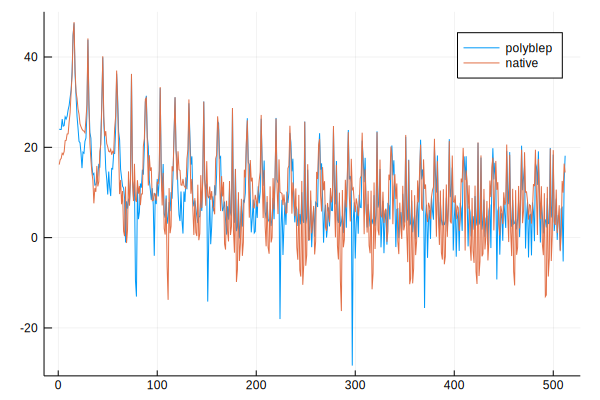

In [31]:
plot(20. *log.(10, abs.(fft(a)))[1:fld(length(a),2)], label="polyblep")
plot!(20. *log.(10, abs.(fft(b)))[1:fld(length(a),2)], label="native")

In [32]:
savefig("polyblep.png")